In [1]:
!pip install mtcnn==0.1.1 -q

# Imports

In [2]:
# Common
import time
import os
import csv
import numpy as np

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Ai Model
import tensorflow as tf
from mtcnn.mtcnn import MTCNN

# For multithreading
from concurrent.futures import ThreadPoolExecutor

# Other
from IPython.display import clear_output as cls

# Constant

In [4]:
MODEL_PATH = '/kaggle/input/facenet-tensorflow/tensorflow2/default/2'

CROPPED_IMGS_PATH = '/kaggle/input/bill-gates-images/mbappe/cropped'

# Utils

In [3]:
def get_image_paths(directory, valid_extensions=(".jpg", ".jpeg", ".png", ".bmp", ".gif")):
    image_paths = []
    
    # Iterate over all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if file is an image based on its extension
            if file.lower().endswith(valid_extensions):
                # Append the full path of the image file to the list
                image_paths.append(os.path.join(root, file))
    
    return image_paths


def save_face_embeddings(embedding):
    # Ensure the embedding is a numpy array
    embedding = np.array(embedding)

    # Save to CSV
    with open('avg_face_embeddings.csv', mode="w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(embedding)


def plt_img(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()
    

def preprocess_img(image):
    """
    Preprocess Image:
    
    Args:
        image: np.ndarray
    
    Returns:
        4D(batch_size, height, width, channels)
            'batch_size': This is the number of images (or samples) processed together in one pass through the model.
            'height': The height of each image in pixels.
            'width': The width of each image in pixels.
            'channels': The number of color channels in each image.
    """
    # Dimensions
    IMG_W = 160
    IMG_H = 160
    
    # Resize the image
    image = cv2.resize(image, dsize = (IMG_W, IMG_H))
    
    # Convert image stype or normalize
    image = image.astype(np.float32)/255.0
    
    return image


def image_to_embedding(image: np.ndarray, model_infer):
    """Generate face embedding from an image."""
    
    # Increase image dim
    image_input = image[np.newaxis,...] # (1, 160, 160, 3)
    
    # Perform inference using the callable function
    result = model_infer(tf.convert_to_tensor(image_input, dtype=tf.float32))
    
    # Extract result from output key (1,128)
    embedding = result['Bottleneck_BatchNorm'].numpy()
    
    # Normalize bedding using L2 norm.
    embedding /= np.linalg.norm(embedding, ord=2)
    
    return embedding


def cal_embeddings_dist(embedding_1: np.ndarray, embedding_2: np.ndarray) -> float:
    """
    Compares two embeddings and returns L2 norm of the distance vector.

    Args:
    - embedding_1: A 128-dimensional embedding vector.
    - embedding_2: A 128-dimensional embedding vector.

    Returns:
    - L2 norm of the distance vector
    """

    # Calculate the distance between the embeddings
    embedding_distance = embedding_1 - embedding_2

    # Calculate the L2 norm of the distance vector
    embedding_distance_norm = np.linalg.norm(embedding_distance)
    
    return embedding_distance_norm


def plot_image_grid(images, images_per_row=5, total_images=50):
    # Ensure we don't exceed the available images or the limit of 50
    total_images = min(total_images, len(images))
    
    # Calculate the number of rows needed
    num_rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    # Flatten the axes array in case of more than one row
    axs = axs.ravel()

    for i in range(total_images):
        # Read and display the image
        img = images[i]
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off the axis for clean presentation

    # Turn off any remaining unused subplots (if total_images < images_per_row * num_rows)
    for j in range(total_images, len(axs)):
        axs[j].axis('off')

    # Show the grid of images
    plt.tight_layout()
    plt.show()
    

def plt_embeddings(embedding):
    # Normalized embedding
    embedding_normalized = (embedding - np.min(embedding)) / (np.max(embedding) - np.min(embedding))
    
    # Plt barcode
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(embedding_normalized)), embedding_normalized)
    plt.show()

# Code

## Step1: Read & Visualize Images

In [6]:
# Read all images
image_paths = get_image_paths(CROPPED_IMGS_PATH)

# Total samples
len(image_paths)

26

In [7]:
training_images = []

# Slice 10 images for training
for idx in range(0, len(image_paths)):
    # Read image
    image = plt.imread(image_paths[idx])

    # Preprocess image to normalize them into (160,160)
    preprocessed_img = preprocess_img(image)
    
    # Append preprocessed image
    training_images.append(preprocessed_img)

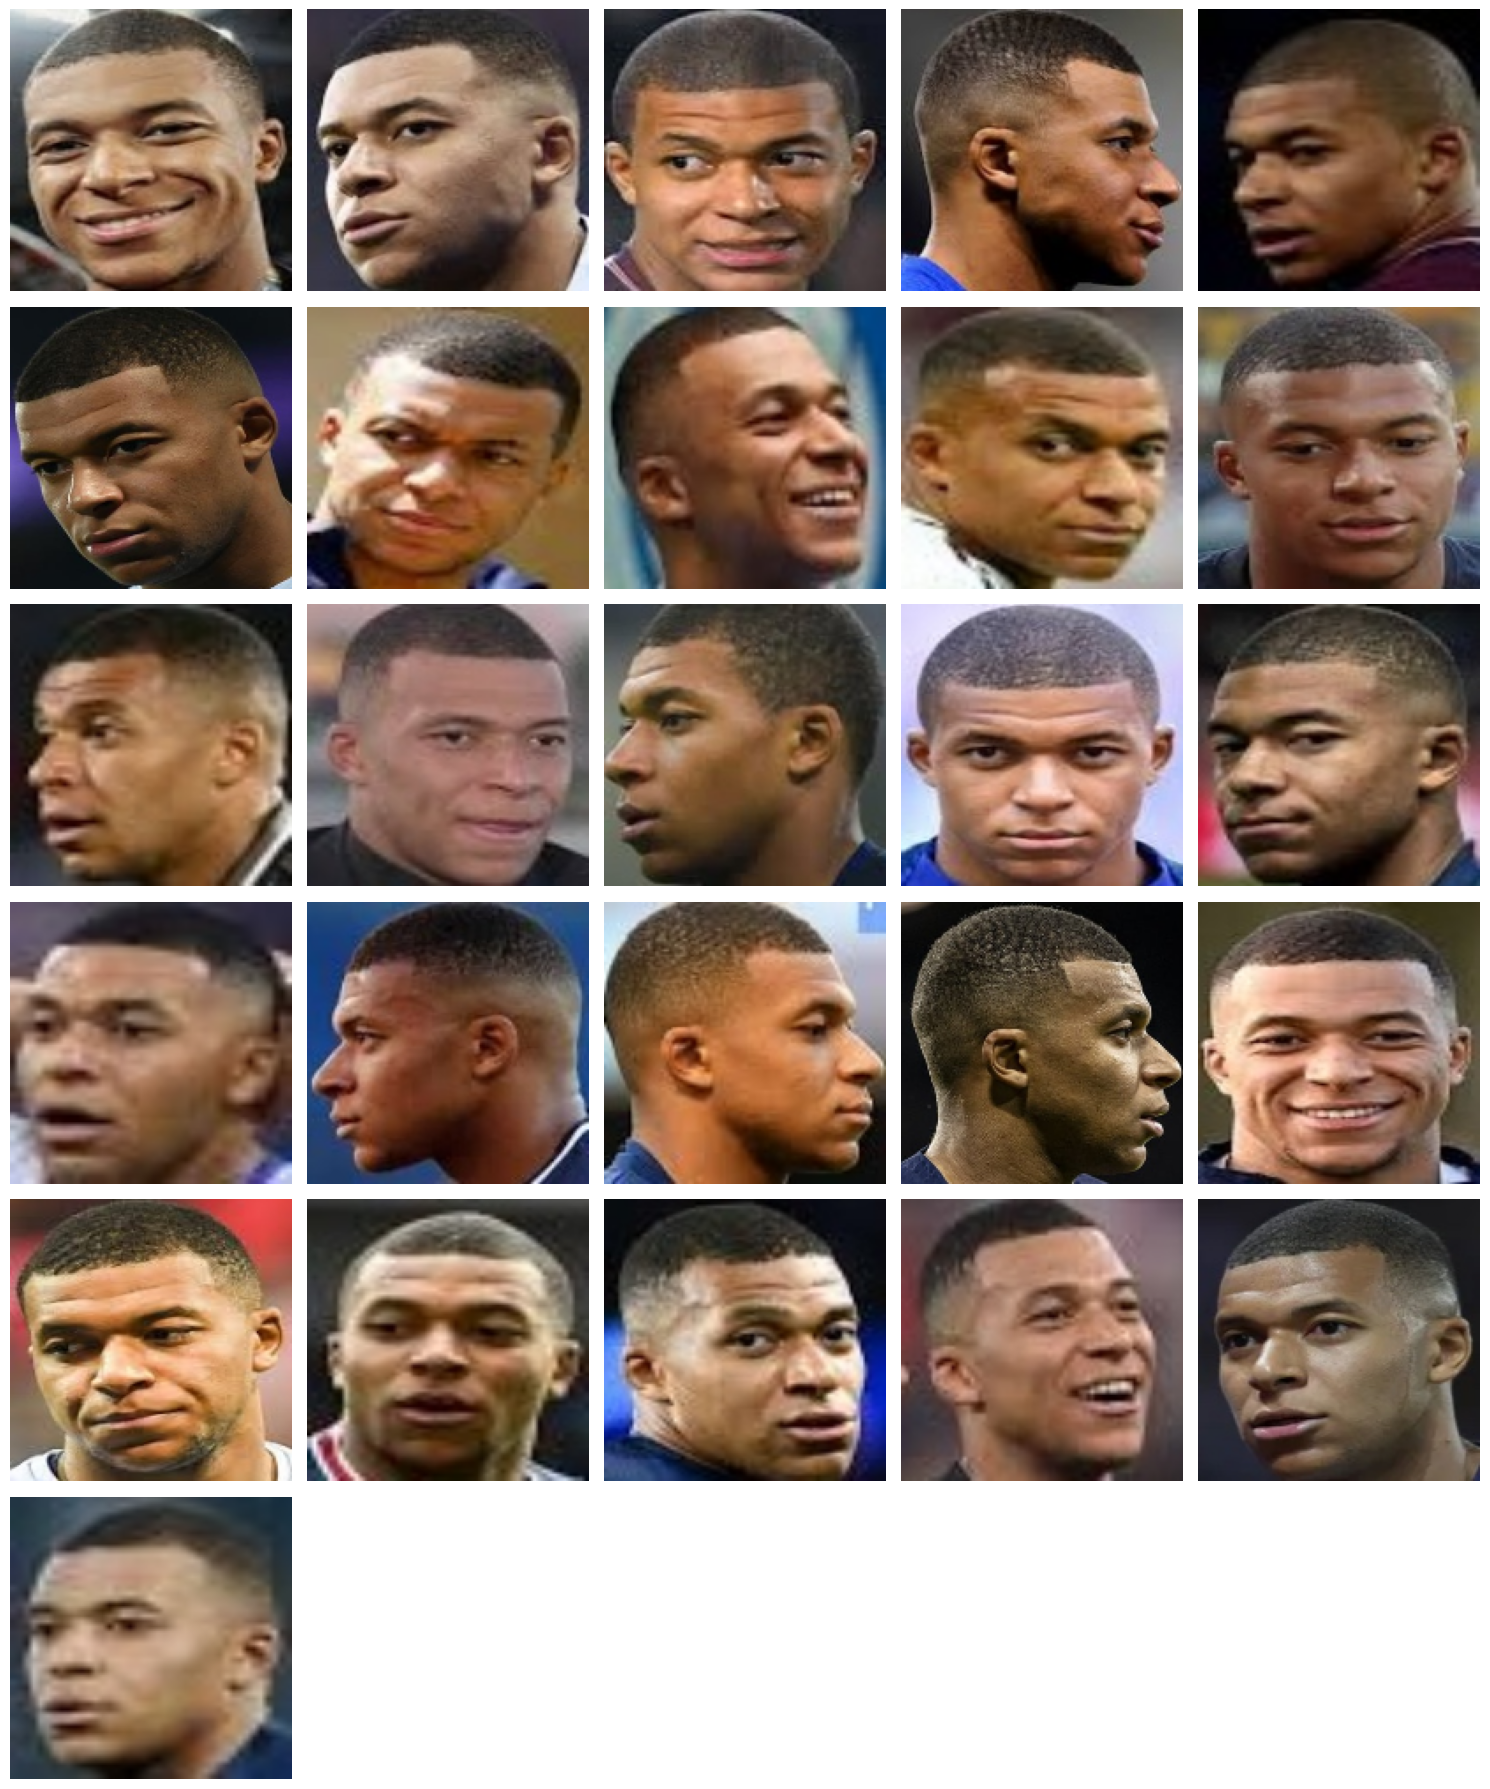

In [8]:
plot_image_grid(training_images)

## Step2: Load Pre-trained FaceNet Model & Generate Embeddings

In [9]:
# Load the model
model = tf.saved_model.load(MODEL_PATH)

# Get the callable function from the loaded model
infer = model.signatures['serving_default']

In [10]:
# Store embeddings
embeddings = np.empty(shape=(len(training_images), 128))

# Generate embeddings
for index, training_img in enumerate(training_images[:10]):
    # Generate embeddings
    embedding = image_to_embedding(training_img, infer)
    
    # Store embeddings
    embeddings[index] = embedding

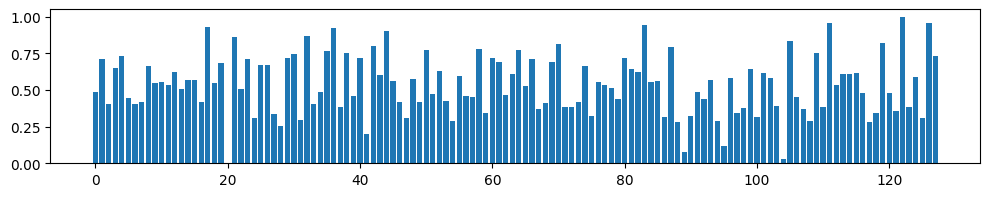

In [11]:
plt_embeddings(embeddings[0])

## Step3: Average Generated Embeddings

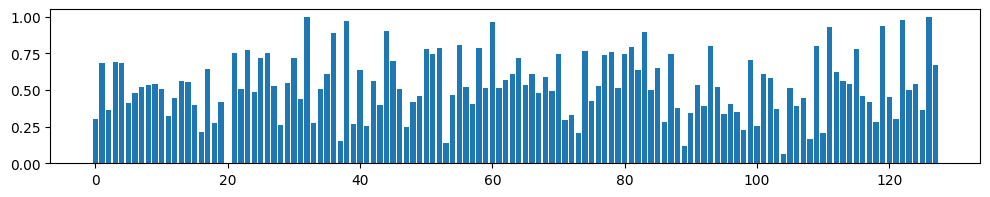

In [12]:
# Compute average embedding
avg_embedding = np.mean(embeddings, axis=0)
plt_embeddings(avg_embedding)

## Step4: Save Embeddings

In [13]:
save_face_embeddings(avg_embedding)